In [2]:
import pandas as pd

nucleus_file 2024.08.02_U2OS_E1_RWM1852_Phalllo568_DAPI_16_1_N1_2.tiff
base_identifier 2024.08.02_U2OS_E1_RWM1852_Phalllo568_DAPI_16_1
cell_file 2024.08.02_U2OS_E1_RWM1852_Phalllo568_DAPI_16_1_L2_1.tiff


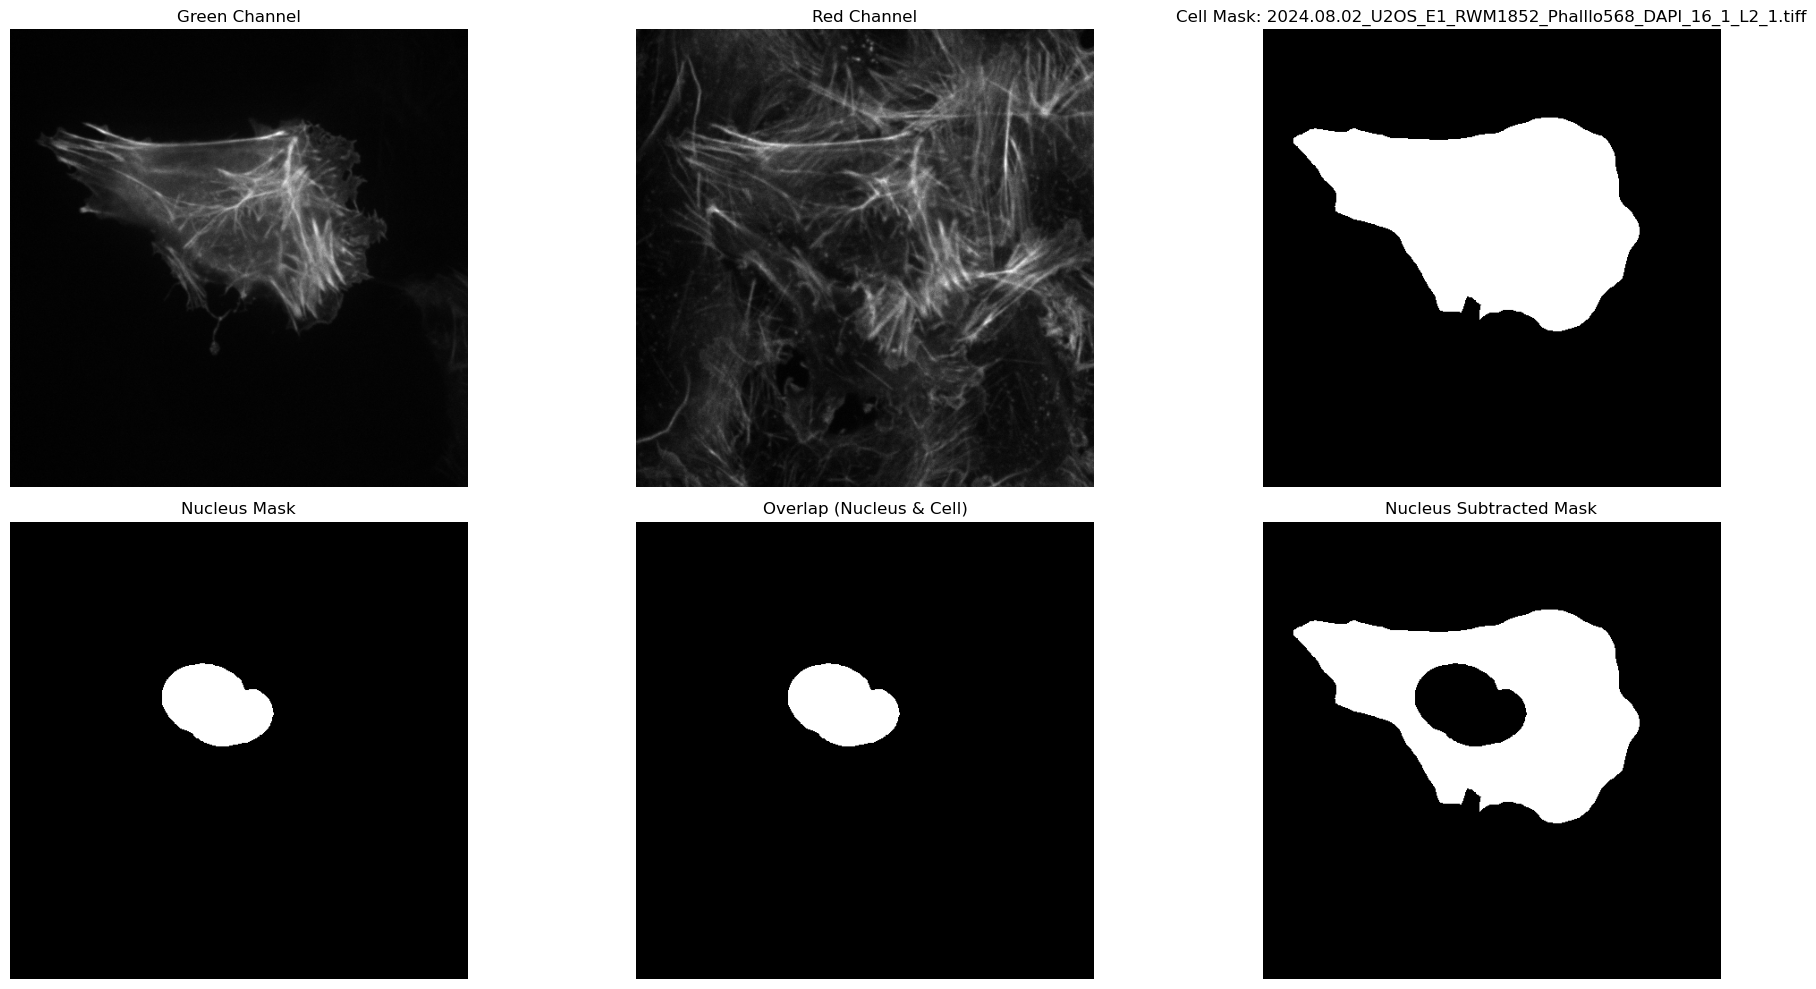

Statistics for 2024.08.02_U2OS_E1_RWM1852_Phalllo568_DAPI_16_1_L2_1.tiff (overlapping with 2024.08.02_U2OS_E1_RWM1852_Phalllo568_DAPI_16_1_N1_2.tiff):
  green_cell: Mean=5671.17, Median=5275.00, StdDev=3149.02
  red_cell: Mean=3441.87, Median=3069.00, StdDev=1690.28
  green_nucleus: Mean=6460.04, Median=6026.50, StdDev=1819.35
  red_nucleus: Mean=2271.92, Median=2047.50, StdDev=963.13


In [58]:
def check_single_file(nucleus_dir, cell_dir, composite_dir, file_index):
    """
    Process a single file from the nucleus mask directory and analyze against all matching cell masks.
    Args:
        nucleus_dir (str): Path to nucleus mask folder.
        cell_dir (str): Path to cell mask folder.
        composite_dir (str): Path to composite image folder.
        file_index (int): Index of the file in the nucleus mask directory.
    """
    # List all files in the nucleus directory
    nucleus_files = sorted([f for f in os.listdir(nucleus_dir) if f.endswith(".tiff")])

    # Ensure the index is within bounds
    if file_index < 0 or file_index >= len(nucleus_files):
        print(f"Invalid file index: {file_index}. Valid range: 0 to {len(nucleus_files) - 1}.")
        return

    # Select the nucleus file
    nucleus_file = nucleus_files[file_index]
    nucleus_path = os.path.join(nucleus_dir, nucleus_file)
    nucleus_mask = cv2.imread(nucleus_path, cv2.IMREAD_GRAYSCALE)
    print("nucleus_file", nucleus_file)
    # Extract the unique identifier from the nucleus file name
    base_identifier = nucleus_file.split("_N")[0]
    print("base_identifier", base_identifier)
    # Find all corresponding cell masks
    cell_files = [f for f in os.listdir(cell_dir) if f.startswith(base_identifier) and "_L" in f]
    if len(cell_files) == 0:
        print(f"No cell mask found for {nucleus_file}.")
        return

    # Find the corresponding composite file
    composite_files = [f for f in os.listdir(composite_dir) if f.startswith(base_identifier) and f.endswith(".tf8")]
    if len(composite_files) != 1:
        print(f"Ambiguous or missing composite file for {nucleus_file}. Found: {composite_files}")
        return
    composite_file = composite_files[0]
    composite_path = os.path.join(composite_dir, composite_file)

    # Open the composite image
    composite_image = tifffile.imread(composite_path)
    green_channel = composite_image[1, :, :]  # 2nd channel
    red_channel = composite_image[2, :, :]    # 3rd channel

    # Analyze each cell mask
    all_stats = {}
    for cell_file in cell_files:
        cell_path = os.path.join(cell_dir, cell_file)
        cell_mask = cv2.imread(cell_path, cv2.IMREAD_GRAYSCALE)
        print("cell_file", cell_file)
        # Check if the nucleus overlaps significantly with the cell mask
        overlap = cv2.bitwise_and(nucleus_mask, cell_mask)
        if np.sum(overlap) / np.sum(nucleus_mask) >= 0.5:  # Threshold for significant overlap
            stats = calculate_statistics(green_channel, red_channel, cell_mask, nucleus_mask)
            all_stats[cell_file] = stats

            # Plot results for this cell mask
            plt.figure(figsize=(20, 10))

            plt.subplot(2, 3, 1)
            plt.imshow(green_channel, cmap='gray')
            plt.title('Green Channel')
            plt.axis('off')

            plt.subplot(2, 3, 2)
            plt.imshow(red_channel, cmap='gray')
            plt.title('Red Channel')
            plt.axis('off')

            plt.subplot(2, 3, 3)
            plt.imshow(cell_mask, cmap='gray')
            plt.title(f'Cell Mask: {cell_file}')
            plt.axis('off')

            plt.subplot(2, 3, 4)
            plt.imshow(nucleus_mask, cmap='gray')
            plt.title('Nucleus Mask')
            plt.axis('off')

            plt.subplot(2, 3, 5)
            plt.imshow(overlap, cmap='gray')
            plt.title('Overlap (Nucleus & Cell)')
            plt.axis('off')

            nucleus_subtracted = cv2.subtract(cell_mask, nucleus_mask)
            plt.subplot(2, 3, 6)
            plt.imshow(nucleus_subtracted, cmap='gray')
            plt.title('Nucleus Subtracted Mask')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    # Print statistics for all overlapping cell masks
    for cell_file, stats in all_stats.items():
        print(f"Statistics for {cell_file} (overlapping with {nucleus_file}):")
        for region, stat in stats.items():
            print(f"  {region}: Mean={stat[0]:.2f}, Median={stat[1]:.2f}, StdDev={stat[2]:.2f}")


def calculate_statistics(green_channel, red_channel, cell_mask, nucleus_mask):
    """
    Calculate mean, median, and standard deviation for regions of interest.
    """
    def stats(region):
        mean = np.mean(region)
        median = np.median(region)
        std_dev = np.std(region)
        return mean, median, std_dev

    # Whole cell
    cell_region = green_channel[cell_mask > 0]
    green_cell_stats = stats(cell_region)
    red_cell_region = red_channel[cell_mask > 0]
    red_cell_stats = stats(red_cell_region)

    # Nucleus
    nucleus_region = green_channel[nucleus_mask > 0]
    green_nucleus_stats = stats(nucleus_region)
    red_nucleus_region = red_channel[nucleus_mask > 0]
    red_nucleus_stats = stats(red_nucleus_region)

    return {
        "green_cell": green_cell_stats,
        "red_cell": red_cell_stats,
        "green_nucleus": green_nucleus_stats,
        "red_nucleus": red_nucleus_stats,
    }


# Directories
nucleus_dir = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Segmentation/Masks/Nuclei/"
cell_dir = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Segmentation/Masks/Cell/"
composite_dir = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Images/"

# Check the ith file
file_index = 17  # Replace with desired index (1 to total number of files)
check_single_file(nucleus_dir, cell_dir, composite_dir, file_index)


In [59]:
import os
import cv2
import numpy as np
import tifffile
import pandas as pd

def check_and_log(nucleus_dir, cell_dir, composite_dir, output_csv_path):
    """
    Process all nucleus mask files, map corresponding cell and composite files, and log the results.
    Args:
        nucleus_dir (str): Path to nucleus mask folder.
        cell_dir (str): Path to cell mask folder.
        composite_dir (str): Path to composite image folder.
        output_csv_path (str): Path to save the log file.
    """
    # List all nucleus mask files
    nucleus_files = sorted([f for f in os.listdir(nucleus_dir) if f.endswith(".tiff")])
    log_data = []

    for nucleus_file in nucleus_files:
        nucleus_path = os.path.join(nucleus_dir, nucleus_file)
        nucleus_mask = cv2.imread(nucleus_path, cv2.IMREAD_GRAYSCALE)

        # Extract the unique identifier from the nucleus file name
        base_identifier = nucleus_file.split("_N")[0]

        # Find all corresponding cell masks
        cell_files = [f for f in os.listdir(cell_dir) if f.startswith(base_identifier) and "_L" in f]

        if len(cell_files) == 0:
            print(f"No cell mask found for {nucleus_file}.")
            continue

        # Find the corresponding composite file
        composite_files = [f for f in os.listdir(composite_dir) if f.startswith(base_identifier) and f.endswith(".tf8")]
        if len(composite_files) != 1:
            print(f"Ambiguous or missing composite file for {nucleus_file}. Found: {composite_files}")
            continue
        composite_file = composite_files[0]

        # Check overlap with each cell mask
        mapped_cell_masks = []
        for cell_file in cell_files:
            cell_path = os.path.join(cell_dir, cell_file)
            cell_mask = cv2.imread(cell_path, cv2.IMREAD_GRAYSCALE)

            # Check if the nucleus overlaps significantly with the cell mask
            overlap = cv2.bitwise_and(nucleus_mask, cell_mask)
            if np.sum(overlap) / np.sum(nucleus_mask) >= 0.5:  # Threshold for significant overlap
                mapped_cell_masks.append(cell_file)

        # Log the results for this nucleus mask
        log_data.append({
            "Nucleus Mask": nucleus_file,
            "Mapped Cell Masks": "; ".join(mapped_cell_masks),
            "Composite File": composite_file,
        })

    # Save the log to a CSV file
    log_df = pd.DataFrame(log_data)
    log_df.to_csv(output_csv_path, index=False)
    print(f"Log file saved to {output_csv_path}")


# Directories
nucleus_dir = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Segmentation/Masks/Nuclei/"
cell_dir = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Segmentation/Masks/Cell/"
composite_dir = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Images/"
output_csv_path = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/log_file.csv"

# Run the process
check_and_log(nucleus_dir, cell_dir, composite_dir, output_csv_path)


No cell mask found for 2024.08.02_U2OS_E1_RWM1853_Phalllo568_DAPI_2_1_N1_1.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1853_Phalllo568_DAPI_2_1_N1_2.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1853_Phalllo568_DAPI_2_1_N1_3.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1853_Phalllo568_DAPI_6_1_N1_1.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1853_Phalllo568_DAPI_6_1_N1_2.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1853_Phalllo568_DAPI_6_1_N1_3.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1853_Phalllo568_DAPI_8_1_N1_1.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1853_Phalllo568_DAPI_8_1_N1_2.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1854_Phalllo568_DAPI_5_1_N1_1.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1854_Phalllo568_DAPI_6_1_N1_1.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1856_Phalllo568_DAPI_11_1_N1_1.tiff.
No cell mask found for 2024.08.02_U2OS_E1_RWM1856_Phalllo568_DAPI_11_1_N1_2.tiff.
No cell mask found for 202

In [65]:
# Load the newly uploaded Green and Red measurement files
green_file_path_new = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Nuclear_signal/Output_1/measurements.csv'

# Define the list of valid constructs to extract
valid_constructs = [
    'RWM1852', 'RWM1853', 'RWM1854', 'RWM1855',
    'RWM1856', 'RWM986', 'RWM817', 'RWM317'
]

# Create a regex pattern that matches the valid constructs
construct_pattern = '|'.join(valid_constructs)

# Process the Green measurements file
green_data_new = pd.read_csv(green_file_path_new)
green_data_new['Construct'] = green_data_new['Cell Mask'].str.extract(f'({construct_pattern})')

# Save the updated Green measurements file
corrected_green_file_path_new = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Nuclear_signal/Output_1/measurements.csv'
green_data_new.to_csv(corrected_green_file_path_new, index=False)



corrected_green_file_path_new


'/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Nuclear_signal/Output_1/measurements.csv'

In [62]:
import os
import cv2
import numpy as np
import tifffile
import pandas as pd


def create_output_subfolders(base_output_dir):
    """
    Create subfolders for output masks in the main output directory.
    Args:
        base_output_dir (str): The main output directory path.
    """
    # Define subfolder names
    subfolders = ["Nuclei_Masks", "Nucleus_Subtracted_Masks"]

    # Create each subfolder
    for subfolder in subfolders:
        subfolder_path = os.path.join(base_output_dir, subfolder)
        os.makedirs(subfolder_path, exist_ok=True)
        print(f"Created/Verified subfolder: {subfolder_path}")

    return {subfolder: os.path.join(base_output_dir, subfolder) for subfolder in subfolders}


def process_all_files(nucleus_dir, cell_dir, composite_dir, output_dirs, csv_save_path):
    """
    Process all nucleus masks, analyze corresponding cell masks, and save results.
    Args:
        nucleus_dir (str): Path to nucleus mask folder.
        cell_dir (str): Path to cell mask folder.
        composite_dir (str): Path to composite image folder.
        output_dirs (dict): Output directories for masks.
        csv_save_path (str): Path to save the CSV file with measurements.
    """
    # Initialize results list
    results = []

    # List all nucleus files
    nucleus_files = sorted([f for f in os.listdir(nucleus_dir) if f.endswith(".tiff")])

    for nucleus_file in nucleus_files:
        nucleus_path = os.path.join(nucleus_dir, nucleus_file)
        nucleus_mask = cv2.imread(nucleus_path, cv2.IMREAD_GRAYSCALE)

        # Extract the unique identifier from the nucleus file name
        base_identifier = nucleus_file.split("_N")[0]

        # Find all corresponding cell masks
        cell_files = [f for f in os.listdir(cell_dir) if f.startswith(base_identifier) and "_L" in f]

        # Find the corresponding composite file
        composite_files = [f for f in os.listdir(composite_dir) if f.startswith(base_identifier) and f.endswith(".tf8")]
        if len(composite_files) != 1:
            print(f"Ambiguous or missing composite file for {nucleus_file}. Found: {composite_files}")
            continue
        composite_file = composite_files[0]
        composite_path = os.path.join(composite_dir, composite_file)

        # Open the composite image
        composite_image = tifffile.imread(composite_path)
        green_channel = composite_image[1, :, :]  # 2nd channel
        red_channel = composite_image[2, :, :]    # 3rd channel

        # Resize masks to match image dimensions if necessary
        image_shape = green_channel.shape

        for cell_file in cell_files:
            cell_path = os.path.join(cell_dir, cell_file)
            cell_mask = cv2.imread(cell_path, cv2.IMREAD_GRAYSCALE)

            if cell_mask.shape != image_shape:
                cell_mask = cv2.resize(cell_mask, (image_shape[1], image_shape[0]))

            if nucleus_mask.shape != image_shape:
                nucleus_mask = cv2.resize(nucleus_mask, (image_shape[1], image_shape[0]))

            # Check if the nucleus overlaps significantly with the cell mask
            overlap = cv2.bitwise_and(nucleus_mask, cell_mask)
            if np.sum(overlap) / np.sum(nucleus_mask) >= 0.5:  # Threshold for significant overlap
                # Calculate statistics
                nucleus_subtracted_mask = cv2.subtract(cell_mask, nucleus_mask)
                stats = calculate_statistics(green_channel, red_channel, cell_mask, nucleus_mask, nucleus_subtracted_mask)

                # Append results
                results.append({
                    "Nucleus Mask": nucleus_file,
                    "Cell Mask": cell_file,
                    "Composite Image": composite_file,
                    "Green Whole Cell Mean": stats["green_cell"][0],
                    "Green Whole Cell Median": stats["green_cell"][1],
                    "Green Whole Cell StdDev": stats["green_cell"][2],
                    "Red Whole Cell Mean": stats["red_cell"][0],
                    "Red Whole Cell Median": stats["red_cell"][1],
                    "Red Whole Cell StdDev": stats["red_cell"][2],
                    "Green Nucleus Mean": stats["green_nucleus"][0],
                    "Green Nucleus Median": stats["green_nucleus"][1],
                    "Green Nucleus StdDev": stats["green_nucleus"][2],
                    "Red Nucleus Mean": stats["red_nucleus"][0],
                    "Red Nucleus Median": stats["red_nucleus"][1],
                    "Red Nucleus StdDev": stats["red_nucleus"][2],
                    "Green Nucleus-Subtracted Mean": stats["green_nucleus_subtracted"][0],
                    "Green Nucleus-Subtracted Median": stats["green_nucleus_subtracted"][1],
                    "Green Nucleus-Subtracted StdDev": stats["green_nucleus_subtracted"][2],
                    "Red Nucleus-Subtracted Mean": stats["red_nucleus_subtracted"][0],
                    "Red Nucleus-Subtracted Median": stats["red_nucleus_subtracted"][1],
                    "Red Nucleus-Subtracted StdDev": stats["red_nucleus_subtracted"][2]
                })

                # Save nucleus mask overlap
                nucleus_overlap_path = os.path.join(output_dirs["Nuclei_Masks"], cell_file)
                cv2.imwrite(nucleus_overlap_path, overlap)

                # Save nucleus-subtracted mask
                nucleus_subtracted_path = os.path.join(output_dirs["Nucleus_Subtracted_Masks"], cell_file)
                cv2.imwrite(nucleus_subtracted_path, nucleus_subtracted_mask)

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(csv_save_path, index=False)
    print(f"Results saved to {csv_save_path}")


def calculate_statistics(green_channel, red_channel, cell_mask, nucleus_mask, nucleus_subtracted_mask):
    """
    Calculate mean, median, and standard deviation for regions of interest.
    """
    def stats(region):
        mean = np.mean(region)
        median = np.median(region)
        std_dev = np.std(region)
        return mean, median, std_dev

    # Ensure the masks are correctly applied to 2D image arrays
    cell_mask = cell_mask.astype(np.bool_)
    nucleus_mask = nucleus_mask.astype(np.bool_)
    nucleus_subtracted_mask = nucleus_subtracted_mask.astype(np.bool_)

    # Whole cell
    cell_region = green_channel[cell_mask]
    green_cell_stats = stats(cell_region)
    red_cell_region = red_channel[cell_mask]
    red_cell_stats = stats(red_cell_region)

    # Nucleus
    nucleus_region = green_channel[nucleus_mask]
    green_nucleus_stats = stats(nucleus_region)
    red_nucleus_region = red_channel[nucleus_mask]
    red_nucleus_stats = stats(red_nucleus_region)

    # Nucleus-subtracted region
    nucleus_subtracted_region = green_channel[nucleus_subtracted_mask]
    green_nucleus_subtracted_stats = stats(nucleus_subtracted_region)
    red_nucleus_subtracted_region = red_channel[nucleus_subtracted_mask]
    red_nucleus_subtracted_stats = stats(red_nucleus_subtracted_region)

    return {
        "green_cell": green_cell_stats,
        "red_cell": red_cell_stats,
        "green_nucleus": green_nucleus_stats,
        "red_nucleus": red_nucleus_stats,
        "green_nucleus_subtracted": green_nucleus_subtracted_stats,
        "red_nucleus_subtracted": red_nucleus_subtracted_stats,
    }


# Directories
nucleus_dir = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Segmentation/Masks/Nuclei/"
cell_dir = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Segmentation/Masks/Cell/"
composite_dir = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Images/"
main_output_dir = "/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Nuclear_signal/Output_1/"
csv_save_path = os.path.join(main_output_dir, "measurements.csv")

# Create subfolders for output
output_dirs = create_output_subfolders(main_output_dir)

# Run the processing
process_all_files(nucleus_dir, cell_dir, composite_dir, output_dirs, csv_save_path)


Created/Verified subfolder: /home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Nuclear_signal/Output_1/Nuclei_Masks
Created/Verified subfolder: /home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Nuclear_signal/Output_1/Nucleus_Subtracted_Masks


/tmp/ipykernel_194/3294811757.py:80: RuntimeWarning: invalid value encountered in scalar divide
  if np.sum(overlap) / np.sum(nucleus_mask) >= 0.5:  # Threshold for significant overlap


Results saved to /home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Nuclear_signal/Output_1/measurements.csv
